<h2 align=center> Fine-Tune BERT for Text Classification with TensorFlow</h2>

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 1: BERT Classification Model</p>
</div>

The pretrained BERT model used in this project is [available](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) on [TensorFlow Hub](https://tfhub.dev/).

### Plan:

- Build TensorFlow Input Pipelines for Text Data with the [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) API
- Tokenize and Preprocess Text for BERT
- Fine-tune BERT for text classification with TensorFlow 2 and [TF Hub](https://tfhub.dev)

### Contents

- **[0]()**: Prepare/check GPU, import libraries
- **[1]()**: Download and Import the Quora Insincere Questions Dataset
- **[2]()**: Create tf.data.Datasets for Training and Evaluation
- **[3]()**: Download a Pre-trained BERT Model from TensorFlow Hub
- **[4]()**: Tokenize and Preprocess Text for BERT
- **[5]()**: Wrap a Python Function into a TensorFlow op for Eager Execution
- **[6]()**: Create a TensorFlow Input Pipeline with `tf.data`
- **[7]()**: Add a Classification Head to the BERT `hub.KerasLayer`
- **[8]()**: Fine-Tune BERT for Text Classification
- **[9]()**: Evaluate the BERT Text Classification Model

## 0: Prepare/check GPU, import libraries

In [1]:
!nvidia-smi

Tue Sep 29 21:17:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install TensorFlow and TensorFlow Model Garden

In [2]:
import tensorflow as tf
print(tf.version.VERSION)

2.3.0


In [ ]:
# !pip install -q tensorflow==2.3.0

In [3]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2318/2318), done.
remote: Total 2650 (delta 512), reused 1350 (delta 299), pack-reused 0
Receiving objects: 100% (2650/2650), 34.01 MiB | 33.72 MiB/s, done.
Resolving deltas: 100% (512/512), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [ ]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

## 1: Download and Import the Quora Insincere Questions Dataset

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [2]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.3.0
Eager mode:  True
Hub version:  0.9.0
GPU is available


A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip', 
                 compression='zip',
                 low_memory=False)
df.shape

(1306122, 3)

In [4]:
df.tail()

,qid,question_text,target
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0
1306121,ffffed09fedb5088744a,Who wins in a battle between a Wolverine and a...,0


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Number of neutral: 1225312, number of dangerous: 80810


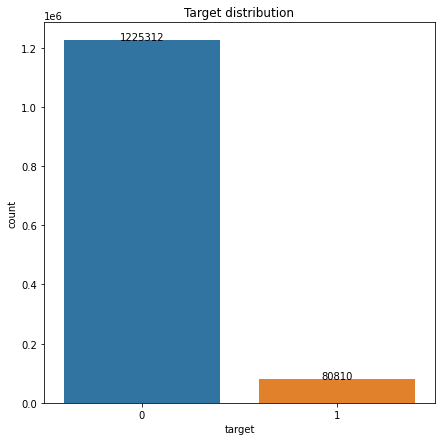

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
labels = df.target.value_counts().index
values = df.target.value_counts().values
ax = sns.countplot(df.target, label='Count')
plt.title('Target distribution')
neutr, dang = df.target.value_counts()
print(f'Number of neutral: {neutr}, number of dangerous: {dang}')

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.1, values[i], ha='center')
plt.show();

In [9]:
df.target.value_counts(normalize=True)

0    0.93813
1    0.06187
Name: target, dtype: float64

## 2: Create tf.data.Datasets for Training and Evaluation

In [10]:
train_df, remaining = train_test_split(df, random_state=42, 
                                       train_size=0.0075, stratify=df.target.values)
valid_df, _ = train_test_split(remaining, random_state=42, 
                                      train_size=0.00075, stratify = remaining.target.values)

train_df.shape, valid_df.shape

((9795, 3), (972, 3))

In [11]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df.question_text.values, train_df.target.values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df.question_text.values, valid_df.target.values))

  for text, label in train_data.take(2):
      print(text, label)

tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'Which war changed the course of history of the world?', shape=(), dtype=string) tf.Tensor(0, shape=(), dtype=int64)


## 3: Download a Pre-trained BERT Model from TensorFlow Hub

In [12]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

 # Label categories
label_list = [0, 1]
 # maximum length of (token) input sequences, possible to change
max_seq_length = 128
train_batch_size=32

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2', trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)


In [13]:
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [14]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

## 4: Tokenize and Preprocess Text for BERT

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

In [15]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid = None, 
                                             text_a = text.numpy(),
                                             text_b=None,
                                             label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)
  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

You want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So you can't `.map` this function directly: You need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

## 5: Wrap a Python Function into a TensorFlow op for Eager Execution

In [16]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label],
                                                                Tout = [tf.int32, tf.int32, tf.int32, tf.int32])
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
       'input_word_ids': input_ids,
       'input_mask': input_mask,
       'input_type_ids': segment_ids
  }
  
  return (x, label_id)

## 6: Create a TensorFlow Input Pipeline with `tf.data`

In [17]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map, 
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map, 
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))
  

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [18]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [19]:
# valid data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

## 7: Add a Classification Head to the BERT Layer

In [20]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                        name="input_type_ids")
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(drop)
  model = tf.keras.Model(inputs = {
                            'input_word_ids': input_word_ids,
                            'input_mask': input_mask,
                            'input_type_ids': input_type_ids},
                        outputs = output)
  return model

## 8: Fine-Tune BERT for Text Classification

In [21]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

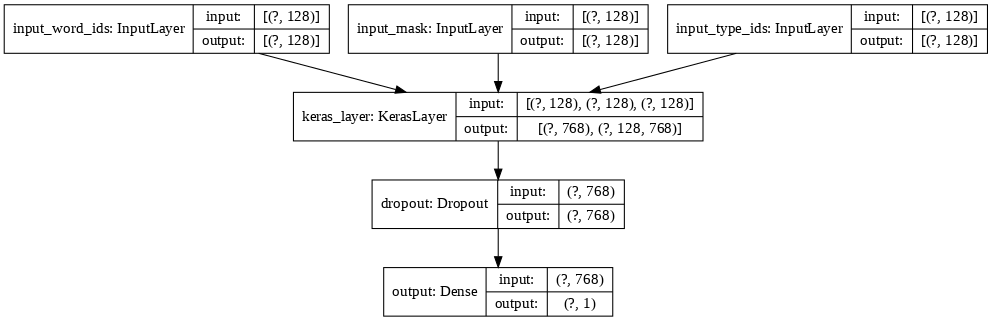

In [22]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

In [23]:
# Train model
epochs = 3
history = model.fit(train_data,
                    validation_data = valid_data,
                    epochs=epochs,
                    verbose=1)

Epoch 1/3
306/306 [==============================] - ETA: 0s - loss: 0.1941 - binary_accuracy: 0.9319WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0157s vs `on_test_batch_end` time: 0.1370s). Check your callbacks.


306/306 [==============================] - 148s 483ms/step - loss: 0.1941 - binary_accuracy: 0.9319 - val_loss: 0.1429 - val_binary_accuracy: 0.9500
Epoch 2/3
306/306 [==============================] - 147s 480ms/step - loss: 0.1053 - binary_accuracy: 0.9590 - val_loss: 0.1230 - val_binary_accuracy: 0.9531
Epoch 3/3
306/306 [==============================] - 147s 480ms/step - loss: 0.0542 - binary_accuracy: 0.9815 - val_loss: 0.1757 - val_binary_accuracy: 0.9510


## 9: Evaluate the BERT Text Classification Model

In [24]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

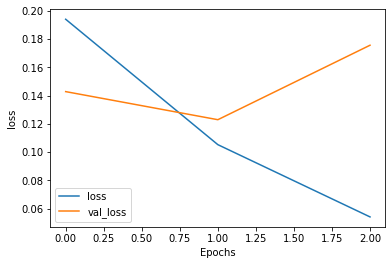

In [25]:
plot_graphs(history, 'loss')

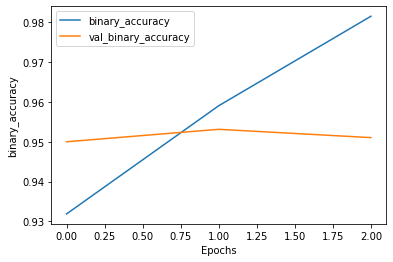

In [26]:
plot_graphs(history, 'binary_accuracy')

In [27]:
sample_example =  ["how are you?", "what is your name?", "why is donald trump such a bad terrible person?"]

test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)
threshold = 0.4
['Toxic' if pred >= threshold else 'Ok' for pred in preds]

['Ok', 'Ok', 'Toxic']